In [1]:
import numpy as np
import pickle
import h5py
import matplotlib.pyplot as plt
from evaluation import get_metric
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import pairwise_distances

In [2]:
cuisine_topk = 5

In [3]:
h5f_train = h5py.File('./Container/train', 'r')
train_features = h5f_train['features_boolean'][:]
train_labels = h5f_train['labels_one_hot'][:]
h5f_train.close()

ingred_num = train_features.shape[1]
cuisine_num = train_labels.shape[1]

In [4]:
h5f_valid = h5py.File('./Container/valid_clf', 'r')
valid_features = h5f_valid['features_boolean'][:]
answer = h5f_valid['labels_int_enc'][:]
h5f_valid.close()

answer_dict = {}
for i, ans in enumerate(answer):
    answer_dict[i] = ans

In [5]:
features_csr = csr_matrix(np.hstack([train_features, train_labels]))
features_csr_T = csr_matrix(features_csr.T)

In [6]:
macro_f1_lst = []
micro_f1_lst = []
acc_lst = []
MAP_lst = []
recall3_lst = []
recall_rank_lst = []

max_dim = 10

for i in range(max_dim):
    model = AlternatingLeastSquares(factors=2**(i+1), regularization=0.01, calculate_training_loss=True)
    model.fit(features_csr)
    
    sim_matrix = 1 - pairwise_distances(model.item_factors, metric="cosine") - np.eye(len(model.item_factors))
    score_matrix = valid_features @ sim_matrix[:-cuisine_num,ingred_num:]
    rec_indices = np.argpartition(score_matrix, -cuisine_topk)[:,-cuisine_topk:]
    
    cuisine_recs = {}
    for query, cuisine_rec_idx in enumerate(rec_indices):
        cuisine_recs[query] = []
        for idx in cuisine_rec_idx:
            cuisine_recs[query].append((idx, score_matrix[query, idx]))
        cuisine_recs[query].sort(key=lambda x : x[1], reverse=True)
        
    with open("./recs/CF_rec_clf_dim_{}.pickle".format(2**i), 'wb') as f:
        pickle.dump(cuisine_recs, f)
        
    metric_dict = get_metric(cuisine_recs, answer_dict, n=3)
    macro_f1_lst.append(metric_dict['macro'])
    micro_f1_lst.append(metric_dict['micro'])
    acc_lst.append(metric_dict['accuracy'])
    MAP_lst.append(metric_dict['map'])
    recall3_lst.append(metric_dict['recall'])
    recall_rank_lst.append(metric_dict['recall_rank'])

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

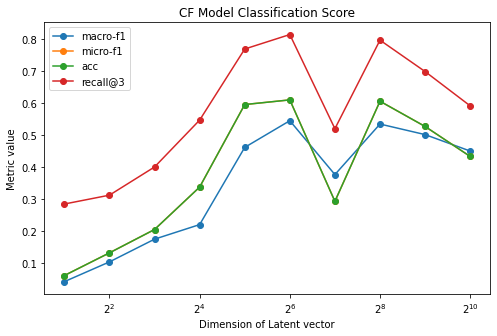

In [7]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, macro_f1_lst, 'o-', label='macro-f1')
plt.plot(dim_lst, micro_f1_lst, 'o-', label='micro-f1')
plt.plot(dim_lst, acc_lst, 'o-', label='acc')
# plt.plot(dim_lst, MAP_lst, 'o-', label='MAP')
plt.plot(dim_lst, recall3_lst, 'o-', label='recall@3')
plt.title("CF Model Classification Score")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('Metric value')
plt.legend()
plt.savefig('./data_analysis/CF_clf_scores.png', dpi=100)
plt.show()

In [ ]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, recall_rank_lst, 'o-', label='avg. recall rank')
plt.title("CF Model Classification Recall Rank")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('recall rank')
plt.legend()
plt.savefig('./data_analysis/CF_clf_recall_rank.png', dpi=100)
plt.show()

In [5]:
macro_f1_lst = []
micro_f1_lst = []
acc_lst = []
MAP_lst = []
recall3_lst = []
recall_rank_lst = []

max_dim = 10

for i in range(max_dim):
    with open("./recs/CF_rec_clf_dim_{}.pickle".format(2**i), 'rb') as f:
        ingred_recs = pickle.load(f)
    
    metric_dict = get_metric(ingred_recs, answer_dict, n=3)
    macro_f1_lst.append(metric_dict['macro'])
    micro_f1_lst.append(metric_dict['micro'])
    acc_lst.append(metric_dict['accuracy'])
    MAP_lst.append(metric_dict['map'])
    recall3_lst.append(metric_dict['recall'])
    recall_rank_lst.append(metric_dict['recall_rank'])

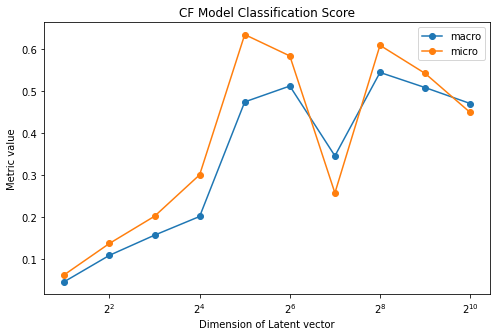

In [6]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, macro_f1_lst, 'o-', label='macro')
plt.plot(dim_lst, micro_f1_lst, 'o-', label='micro')
# plt.plot(dim_lst, MAP_lst, 'o-', label='MAP')
#plt.plot(dim_lst, recall3_lst, 'o-', label='recall@3')
plt.title("CF Model Classification Score")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('Metric value')
plt.legend()
plt.savefig('./data_analysis/CF_clf_scores.png', dpi=100)
plt.show()

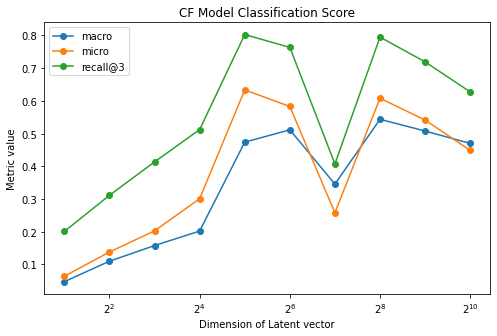

In [7]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, macro_f1_lst, 'o-', label='macro')
plt.plot(dim_lst, micro_f1_lst, 'o-', label='micro')
plt.plot(dim_lst, recall3_lst, 'o-', label='recall@3')
plt.title("CF Model Classification Score")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('Metric value')
plt.legend()
plt.savefig('./data_analysis/CF_clf_entire_scores.png', dpi=100)
plt.show()

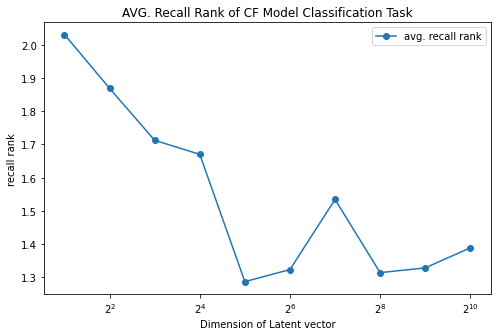

In [8]:
dim_lst = [2**(i+1) for i in range(max_dim)]

plt.figure(figsize=(8,5))
plt.plot(dim_lst, recall_rank_lst, 'o-', label='avg. recall rank')
plt.title("AVG. Recall Rank of CF Model Classification Task")
plt.xscale('log', base=2)
plt.xlabel('Dimension of Latent vector')
plt.ylabel('recall rank')
plt.legend()
plt.savefig('./data_analysis/CF_clf_recall_rank.png', dpi=100)
plt.show()

In [9]:
max(macro_f1_lst)

0.543450798586031